# **ANN for MNIST digit Classification**  
**Date:** 27/01/25  

**B RITESH KUMAR**  
**Roll Number:** CS22B2043  

Q1. Classify MNIST digits using Fully Connected Neural network.
Dataset : download from internet source

-Plot few samples from dataset \
-Train the network \
-Test on the test dataset \
-Calculate test accuracy on test set



# Modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical #For making the output one hot encoded
from sklearn.preprocessing import StandardScaler

# Load The Data

In [3]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Display the shapes and details of the training and testing data
print(f"Training data shape: {x_train.shape}")
print(f"Testing data shape: {x_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training data shape: (60000, 28, 28)
Testing data shape: (10000, 28, 28)
Training labels shape: (60000,)
Testing labels shape: (10000,)


# Display the first 10 training images to get an idea of the data

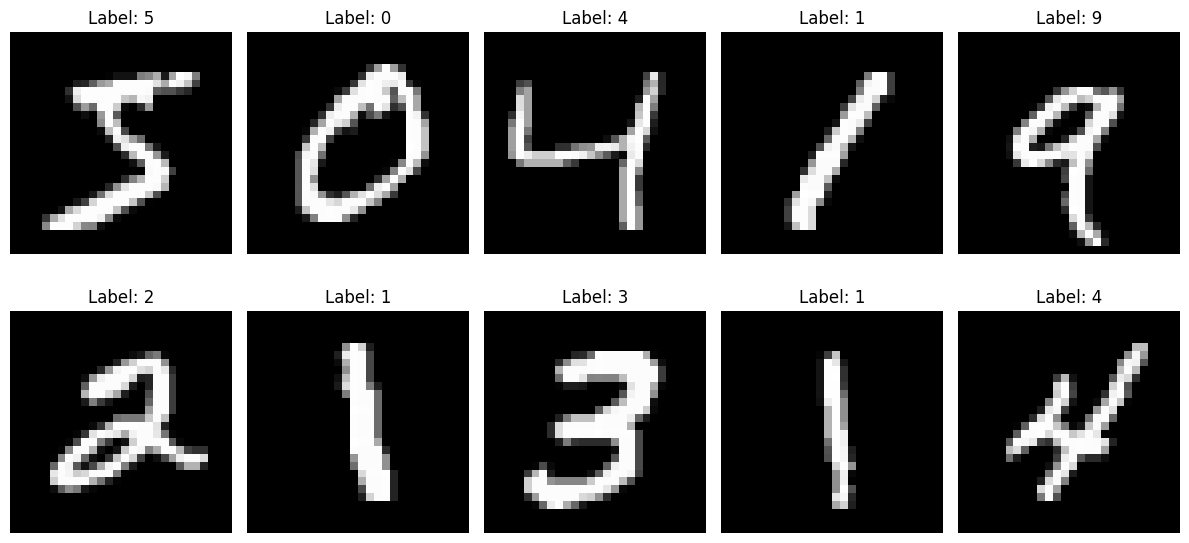

In [4]:
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i], cmap="gray")
    plt.title(f"Label: {y_train[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# Preprocess the Data

In [5]:
x_train = x_train.reshape(-1, 28 * 28).astype(np.float32) / 255.0  # Flatten and normalize
x_test = x_test.reshape(-1, 28 * 28).astype(np.float32) / 255.0

# Standardize the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Initialize weights and biases


In [6]:
np.random.seed(42)
weights_1 = np.random.randn(784, 128) * np.sqrt(2 / 784)
biases_1 = np.zeros((1, 128))

weights_2 = np.random.randn(128, 64) * np.sqrt(2 / 128)
biases_2 = np.zeros((1, 64))

weights_3 = np.random.randn(64, 10) * np.sqrt(2 / 64)
biases_3 = np.zeros((1, 10))

# Activation functions


In [7]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Cross-Entropy Loss function
def cross_entropy_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-12, 1 - 1e-12)  # Prevent log(0)
    return -np.sum(y_true * np.log(y_pred)) / len(y_true)

# Forward pass
def forward_pass(inputs):
    layer_1_inputs = np.dot(inputs, weights_1) + biases_1
    layer_1_outputs = relu(layer_1_inputs)

    layer_2_inputs = np.dot(layer_1_outputs, weights_2) + biases_2
    layer_2_outputs = relu(layer_2_inputs)

    layer_3_inputs = np.dot(layer_2_outputs, weights_3) + biases_3
    outputs = softmax(layer_3_inputs)

    return layer_1_outputs, layer_2_outputs, outputs, (layer_1_inputs, layer_2_inputs, layer_3_inputs)

# Backpropagation
def backpropagation(inputs, y_true, layer_1_outputs, layer_2_outputs, outputs, layer_inputs):
    layer_1_inputs, layer_2_inputs, layer_3_inputs = layer_inputs

    # Output layer gradient using Cross-Entropy loss derivative
    loss_grad = -(y_true - outputs)

    weights_3_grad = np.dot(layer_2_outputs.T, loss_grad)
    biases_3_grad = np.sum(loss_grad, axis=0, keepdims=True)

    layer_2_outputs_grad = np.dot(loss_grad, weights_3.T) * relu_derivative(layer_2_inputs)

    weights_2_grad = np.dot(layer_1_outputs.T, layer_2_outputs_grad)
    biases_2_grad = np.sum(layer_2_outputs_grad, axis=0, keepdims=True)

    layer_1_outputs_grad = np.dot(layer_2_outputs_grad, weights_2.T) * relu_derivative(layer_1_inputs)

    weights_1_grad = np.dot(inputs.T, layer_1_outputs_grad)
    biases_1_grad = np.sum(layer_1_outputs_grad, axis=0, keepdims=True)

    return weights_1_grad, biases_1_grad, weights_2_grad, biases_2_grad, weights_3_grad, biases_3_grad

# Training the model with mini-batch gradient descent


In [8]:
def train(x_train, y_train, epochs=50, batch_size=64, learning_rate=0.001):
    global weights_1, biases_1, weights_2, biases_2, weights_3, biases_3
    train_losses, train_accuracies = [], []

    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0
        for i in range(0, x_train.shape[0], batch_size):
            batch_x = x_train[i:i + batch_size]
            batch_y = y_train[i:i + batch_size]

            # Forward pass
            layer_1_outputs, layer_2_outputs, outputs, layer_inputs = forward_pass(batch_x)

            # Compute loss
            loss = cross_entropy_loss(batch_y, outputs)
            total_loss += loss

            # Accuracy
            correct_predictions += np.sum(np.argmax(outputs, axis=1) == np.argmax(batch_y, axis=1))

            # Backpropagation
            w1_grad, b1_grad, w2_grad, b2_grad, w3_grad, b3_grad = backpropagation(
                batch_x, batch_y, layer_1_outputs, layer_2_outputs, outputs, layer_inputs
            )

            # Update weights and biases
            weights_1 -= learning_rate * w1_grad
            biases_1 -= learning_rate * b1_grad
            weights_2 -= learning_rate * w2_grad
            biases_2 -= learning_rate * b2_grad
            weights_3 -= learning_rate * w3_grad
            biases_3 -= learning_rate * b3_grad

        # Loss and accuracy for the epoch
        epoch_loss = total_loss / len(x_train)
        epoch_accuracy = correct_predictions / len(x_train)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    return train_losses, train_accuracies

# Train the model


In [9]:
train_losses, train_accuracies = train(x_train, y_train, epochs=20, batch_size=64, learning_rate=0.001)

Epoch 1/20, Loss: 0.0048, Accuracy: 0.9141
Epoch 2/20, Loss: 0.0021, Accuracy: 0.9621
Epoch 3/20, Loss: 0.0014, Accuracy: 0.9748
Epoch 4/20, Loss: 0.0010, Accuracy: 0.9817
Epoch 5/20, Loss: 0.0008, Accuracy: 0.9869
Epoch 6/20, Loss: 0.0006, Accuracy: 0.9912
Epoch 7/20, Loss: 0.0004, Accuracy: 0.9936
Epoch 8/20, Loss: 0.0003, Accuracy: 0.9958
Epoch 9/20, Loss: 0.0003, Accuracy: 0.9971
Epoch 10/20, Loss: 0.0002, Accuracy: 0.9980
Epoch 11/20, Loss: 0.0002, Accuracy: 0.9987
Epoch 12/20, Loss: 0.0001, Accuracy: 0.9991
Epoch 13/20, Loss: 0.0001, Accuracy: 0.9994
Epoch 14/20, Loss: 0.0001, Accuracy: 0.9995
Epoch 15/20, Loss: 0.0001, Accuracy: 0.9997
Epoch 16/20, Loss: 0.0001, Accuracy: 0.9998
Epoch 17/20, Loss: 0.0001, Accuracy: 0.9999
Epoch 18/20, Loss: 0.0000, Accuracy: 0.9999
Epoch 19/20, Loss: 0.0000, Accuracy: 0.9999
Epoch 20/20, Loss: 0.0000, Accuracy: 0.9999


# Plot training loss and accuracy

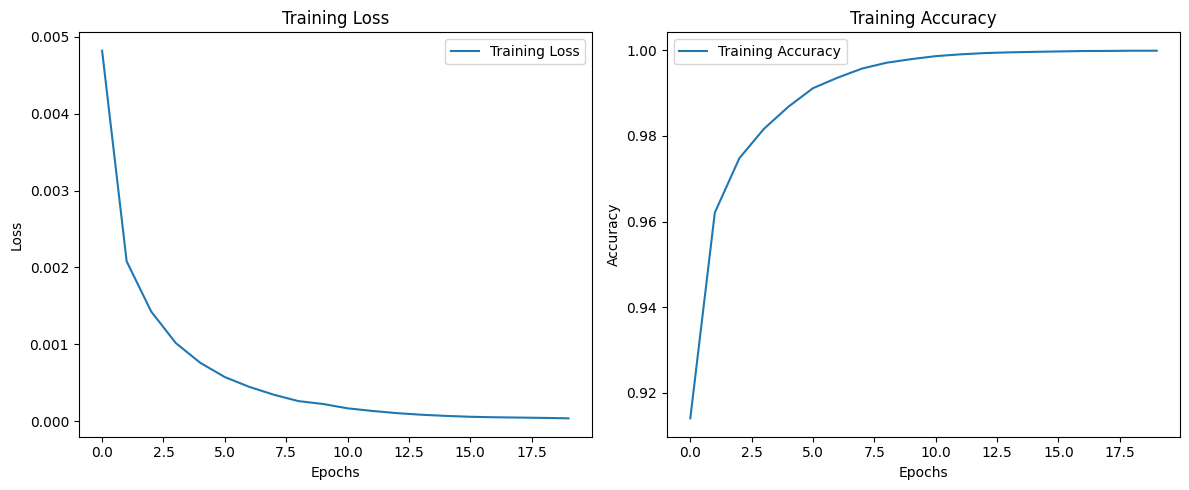

In [10]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Test the model

Test Accuracy: 97.35%


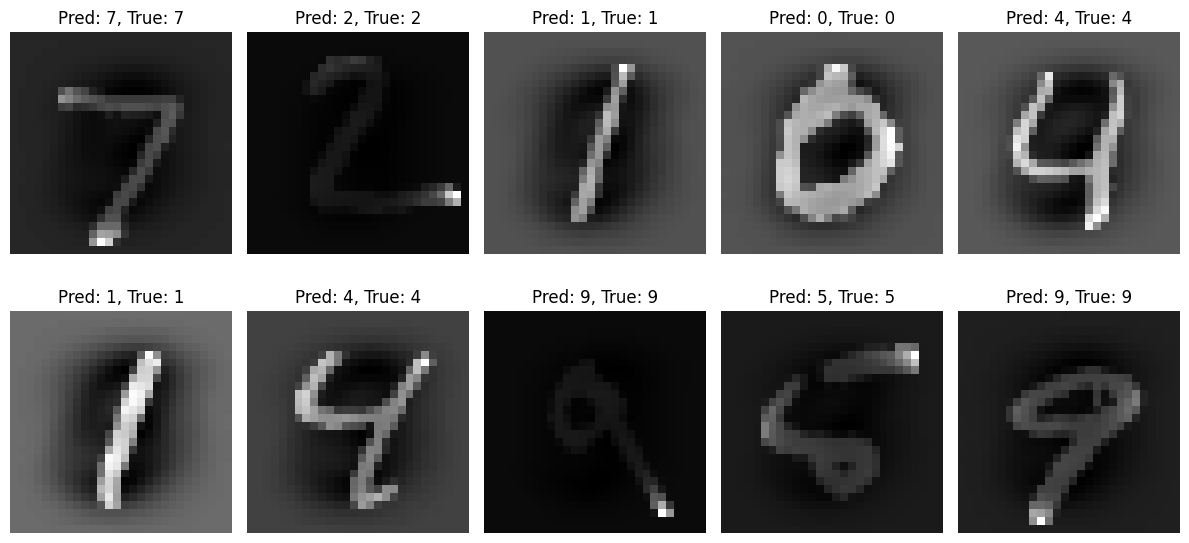

In [11]:
def predict(x):
    _, _, outputs, _ = forward_pass(x)
    return np.argmax(outputs, axis=1)

y_pred = predict(x_test)
test_accuracy = np.mean(y_pred == np.argmax(y_test, axis=1))

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot predictions vs true labels
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.title(f"Pred: {y_pred[i]}, True: {np.argmax(y_test[i])}")
    plt.axis("off")
plt.tight_layout()
plt.show()
